# Face detection using eigenfaces
In this example, we use eigenfaces as a face detector and compare it with Viola - Jones face detector.

In [1]:
# Run some setup code for this notebook.
from time import time
import logging
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pickle

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from data_utils import load_CIFAR_batch
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

We use [LFW](http://vis-www.cs.umass.edu/lfw/) images as positive examples and [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) images as negative examples.

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, slice_=(slice(60, 205, None), slice(68, 182, None)), resize=1)
n_samples, h, w = lfw_people.images.shape
X_lfw = lfw_people.data
X_cifar, _ = load_CIFAR_batch("data/test_batch")

2017-08-03 11:29:06,944 Loading LFW people faces from C:\Users\neiki\scikit_learn_data\lfw_home


Prepare train and test set.

In [3]:
n_test = int(0.2 * n_samples)
n_train = n_samples - n_test
np.random.shuffle(X_lfw)

X_train_faces, X_test_faces = X_lfw[:n_train], X_lfw[n_train:]

test_faces = X_test_faces.reshape(n_test, h, w).astype(np.uint8)

nonface_indices = np.random.choice(len(X_cifar), n_samples)
nonface_color_images = X_cifar[nonface_indices].astype(np.uint8)

# convert nonface_images to grayscale and resize face_images size
nonface_images = []
for i in range(len(nonface_color_images)):
    gray = cv2.cvtColor(nonface_color_images[i], cv2.COLOR_BGR2GRAY)
    resized_gray = cv2.resize(gray, (w, h))
    nonface_images.append(resized_gray)
nonface_images = np.array(nonface_images)

test_nonfaces = nonface_images[n_train:]

# flatten nonface_images for PCA
X_nonfaces = nonface_images.reshape(len(nonface_images), -1)

# split train, test set
X_train_nonfaces, X_test_nonfaces = X_nonfaces[:n_train], X_nonfaces[n_train:]

X_train = np.concatenate((X_train_faces, X_train_nonfaces))
y_train = np.concatenate((np.ones(n_train), np.zeros(n_train)))
X_train, y_train = shuffle(X_train, y_train)

X_test = np.concatenate((X_test_faces, X_test_nonfaces))
y_test = np.concatenate((np.ones(n_test), np.zeros(n_test)))

test_images = np.concatenate((test_faces, test_nonfaces))

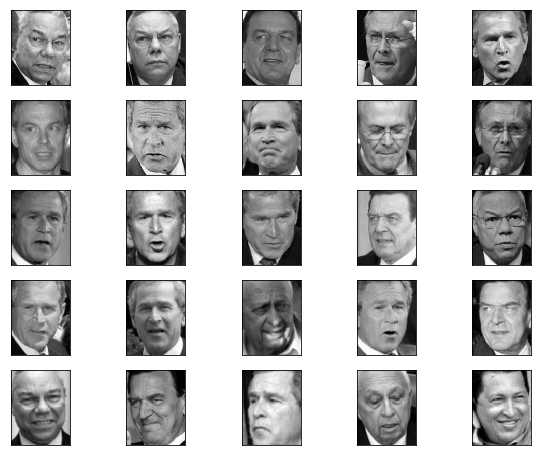

In [4]:
# Visualize some face examples.
n_row = 5
n_col = 5
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(test_faces[i])
    plt.xticks(())
    plt.yticks(())

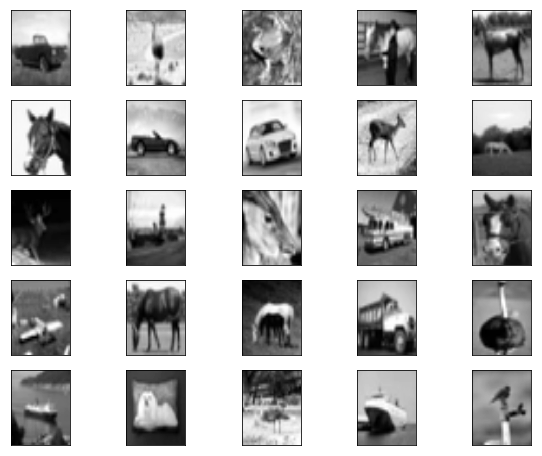

In [5]:
# Visualize some non-face examples.
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(test_nonfaces[i])
    plt.xticks(())
    plt.yticks(())

## Eigenfaces face detection
Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction

In [6]:
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train_faces.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train_faces)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 150 eigenfaces from 1031 faces
done in 5.595s


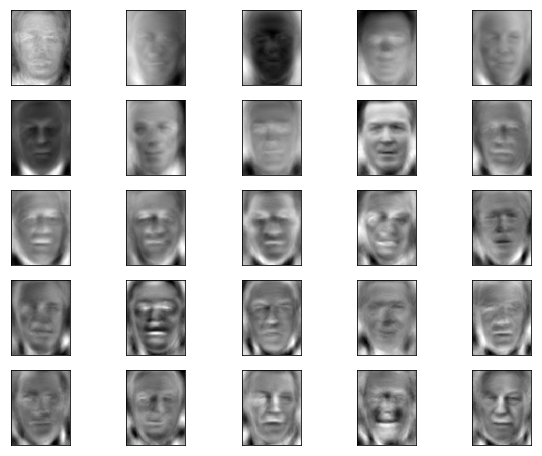

In [7]:
# visualize some eigenfaces
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(eigenfaces[i])
    plt.xticks(())
    plt.yticks(())

In [8]:
print("Projecting the data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Projecting the data on the eigenfaces orthonormal basis
done in 1.254s


Train a SVM binary classification model. Class 0 is non-face. Class 1 is face.

In [9]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 62.597s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Quantitative evaluation of the model quality on the test set

In [10]:
print("Detecting faces on the test set using Eigenface with SVM")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=("nonface", "face")))

Detecting faces on the test set using Eigenface with SVM
done in 0.099s
             precision    recall  f1-score   support

    nonface       0.99      1.00      1.00       257
       face       1.00      0.99      1.00       257

avg / total       1.00      1.00      1.00       514



## Viola - Jones face detection

In [11]:
face_cascade = cv2.CascadeClassifier("data/haarcascades/haarcascade_frontalface_default.xml")
print("Detecting faces on the test set using Cascade Classifier")
t0 = time()
y_pred = []
for i in range(len(test_images)):
    faces = face_cascade.detectMultiScale(test_images[i], scaleFactor=1.1, minNeighbors=3)
    if len(faces) > 0:
        y_pred.append(1.0)
    else: 
        y_pred.append(0.0)
        
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=("nonface", "face")))

Detecting faces on the test set using Cascade Classifier
done in 5.538s
             precision    recall  f1-score   support

    nonface       0.94      0.97      0.96       257
       face       0.97      0.94      0.95       257

avg / total       0.96      0.96      0.96       514

